<a href="https://colab.research.google.com/github/nataliavlrom/progects/blob/main/NSafronova_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Курсовой проект 

## "Прогнозирование невыполнения долговых обязательств по текущему кредиту"

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Целевая метрика**

F1 > 0.5

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Описание датасета:**


**Home Ownership** - домовладение

**Annual Income** - годовой доход

**Years in current job** - количество лет на текущем месте работы

**Tax Liens** - налоговые обременения

**Number of Open Accounts** - количество открытых счетов

**Years of Credit History** - количество лет кредитной истории

**Maximum Open Credit** - наибольший открытый кредит

**Number of Credit Problems** - количество проблем с кредитом

**Months since last delinquent** - количество месяцев с последней просрочки платежа

**Bankruptcies** - банкротства

**Purpose** - цель кредита

**Term** - срок кредита

**Current Loan Amount** - текущая сумма кредита

**Current Credit Balance** - текущий кредитный баланс

**Monthly Debt** - ежемесячный долг

**Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

     |████████████████████████████████| 76.1 MB 55 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
matplotlib.rcParams.update({'font.size': 14})

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [ ]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [ ]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Пути к директориям и файлам**

In [ ]:
TRAIN_DATASET_PATH = '/content/sample_data/course_project_train.csv'
TEST_DATASET_PATH = '/content/sample_data/course_project_test.csv'

**Загрузка данных**

In [ ]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [ ]:
df_train.shape

(7500, 17)

## EDA

In [ ]:
# Целевая переменная
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

###**Количественные переменные**

In [ ]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [ ]:
corelation = df_train.corr()

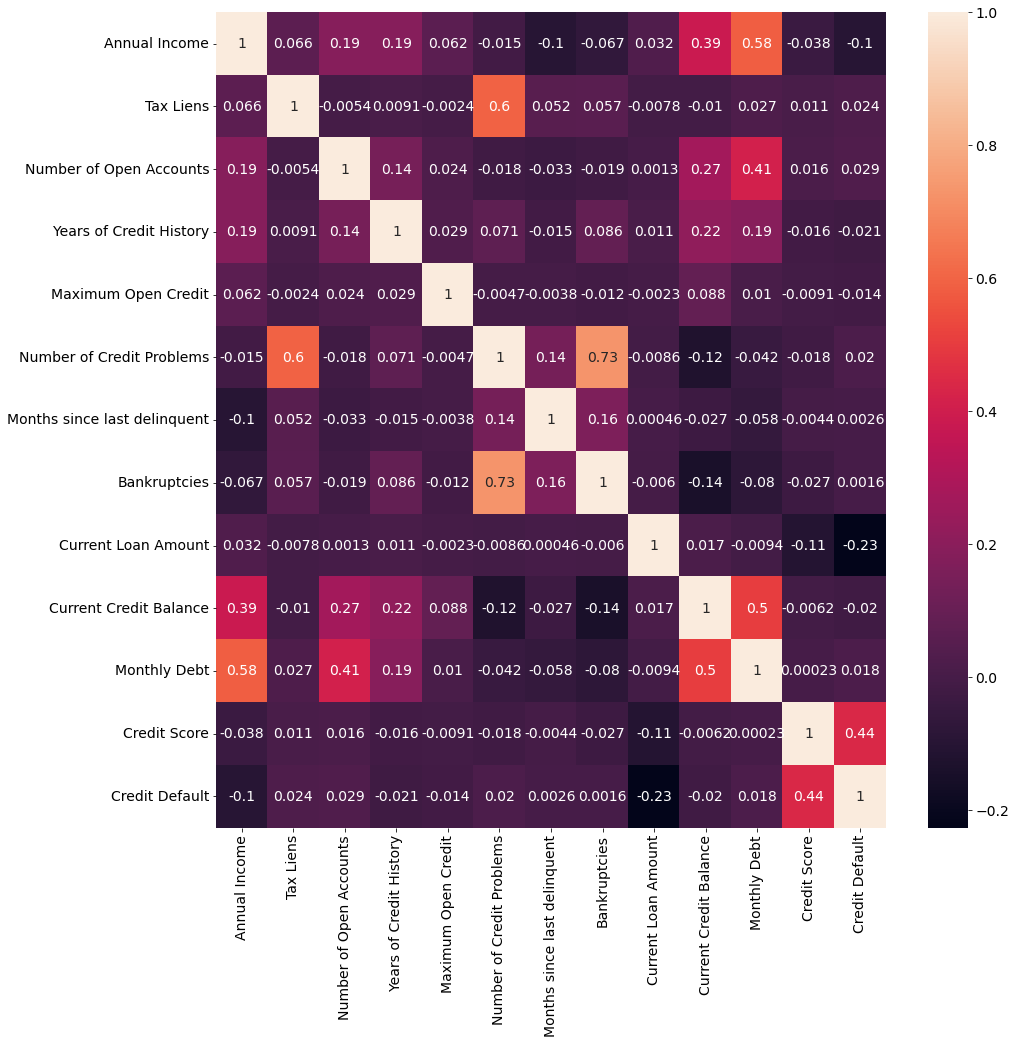

In [ ]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corelation, xticklabels=corelation.columns, yticklabels=corelation.columns, annot=True, ax=ax)

*В таблице представлены коэффициенты корреляции Пирсона между количественными переменными*

###**Качественные переменные**

In [ ]:
df_train.select_dtypes(include='object').columns.tolist()

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [ ]:
df_train['Home Ownership'].value_counts().reset_index()

,index,Home Ownership
0,Home Mortgage,3637
1,Rent,3204
2,Own Home,647
3,Have Mortgage,12


In [ ]:
df_train['Years in current job'].value_counts().reset_index()

,index,Years in current job
0,10+ years,2332
1,2 years,705
2,3 years,620
3,< 1 year,563
4,5 years,516
5,1 year,504
6,4 years,469
7,6 years,426
8,7 years,396
9,8 years,339


In [ ]:
df_train['Purpose'].value_counts().reset_index()

,index,Purpose
0,debt consolidation,5944
1,other,665
2,home improvements,412
3,business loan,129
4,buy a car,96
5,medical bills,71
6,major purchase,40
7,take a trip,37
8,buy house,34
9,small business,26


In [ ]:
df_train['Term'].value_counts().reset_index()

,index,Term
0,Short Term,5556
1,Long Term,1944


###**Обработка выбросов**

Annual Income

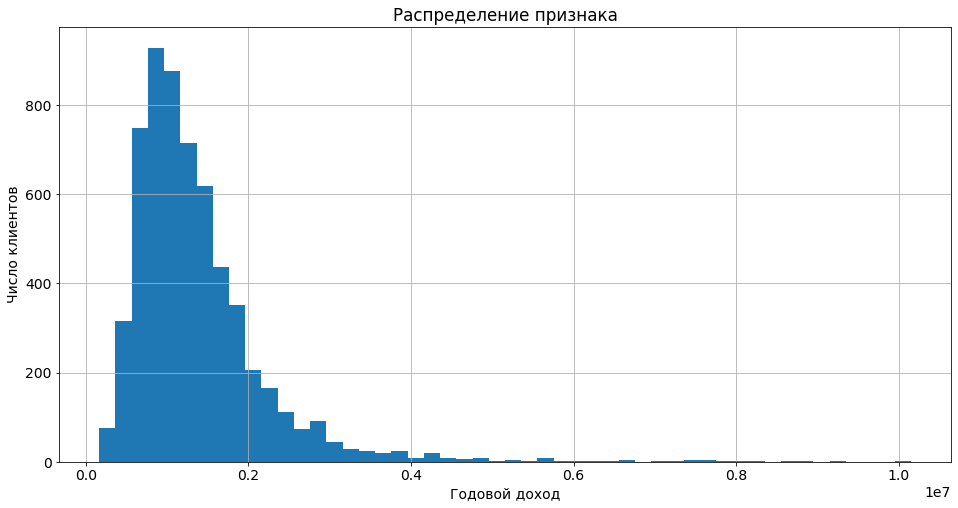

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Annual Income'].hist(bins=50)
plt.ylabel('Число клиентов')
plt.xlabel('Годовой доход')

plt.title('Распределение признака')
plt.show()

In [ ]:
df_train.loc[(df_train['Annual Income'] >= 4000000), 'Annual Income'] = df_train['Annual Income'].median()

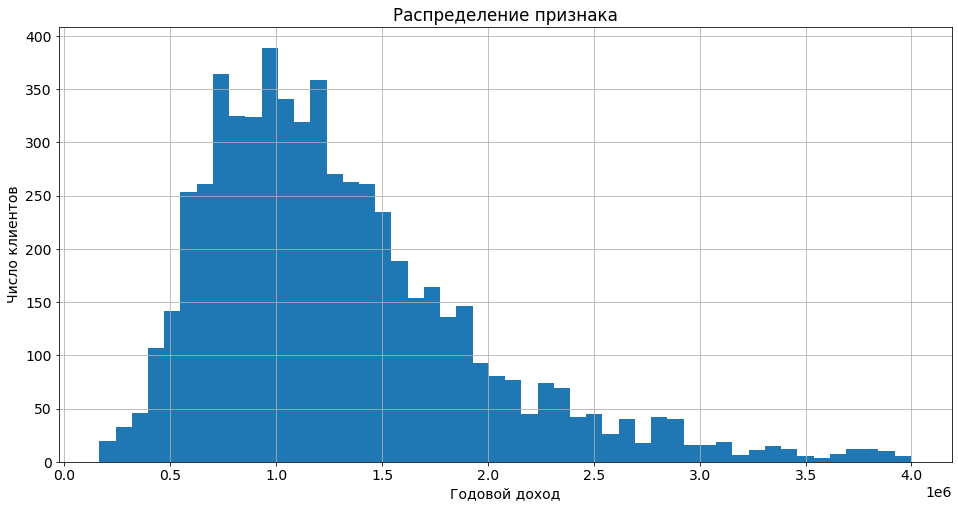

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Annual Income'].hist(bins=50)
plt.ylabel('Число клиентов')
plt.xlabel('Годовой доход')

plt.title('Распределение признака')
plt.show()

Tax Liens

In [ ]:
df_train['Tax Liens'].value_counts().reset_index()

,index,Tax Liens
0,0.0,7366
1,1.0,83
2,2.0,30
3,3.0,10
4,4.0,6
5,6.0,2
6,5.0,2
7,7.0,1


In [ ]:
df_train.loc[(df_train['Tax Liens'] > 3), 'Tax Liens'] = 3

In [ ]:
df_train['Tax Liens'].value_counts().reset_index()

,index,Tax Liens
0,0.0,7366
1,1.0,83
2,2.0,30
3,3.0,21


Number of Open Accounts

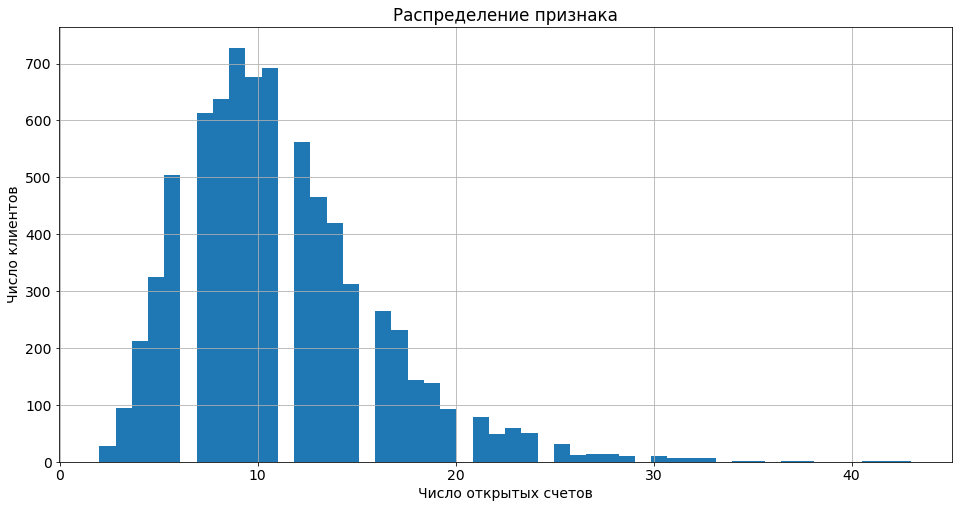

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Number of Open Accounts'].hist(bins=50)
plt.ylabel('Число клиентов')
plt.xlabel('Число открытых счетов')

plt.title('Распределение признака')
plt.show()

In [ ]:
df_train.loc[(df_train['Number of Open Accounts'] >= 25) | (df_train['Number of Open Accounts'] == 0 ),
             'Number of Open Accounts'] = df_train['Number of Open Accounts'].median()

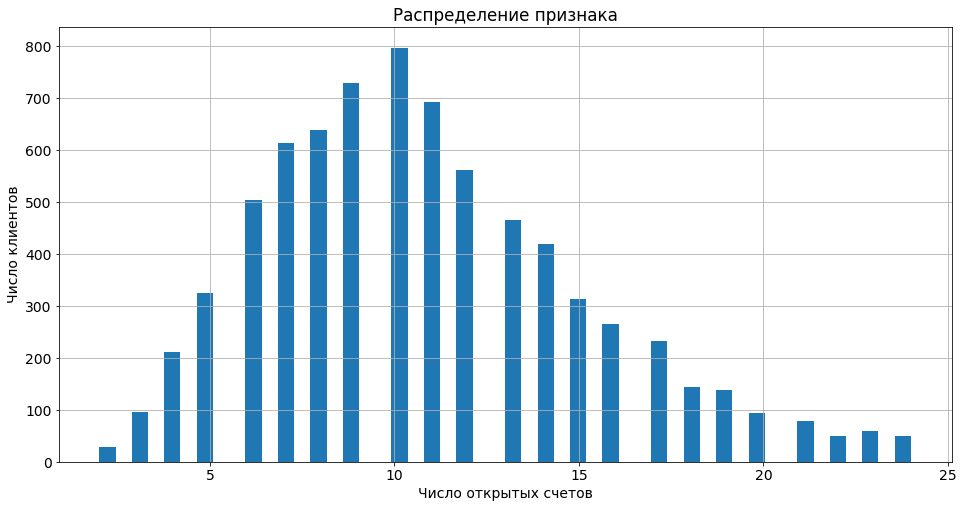

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Number of Open Accounts'].hist(bins=50)
plt.ylabel('Число клиентов')
plt.xlabel('Число открытых счетов')

plt.title('Распределение признака')
plt.show()

Years of Credit History

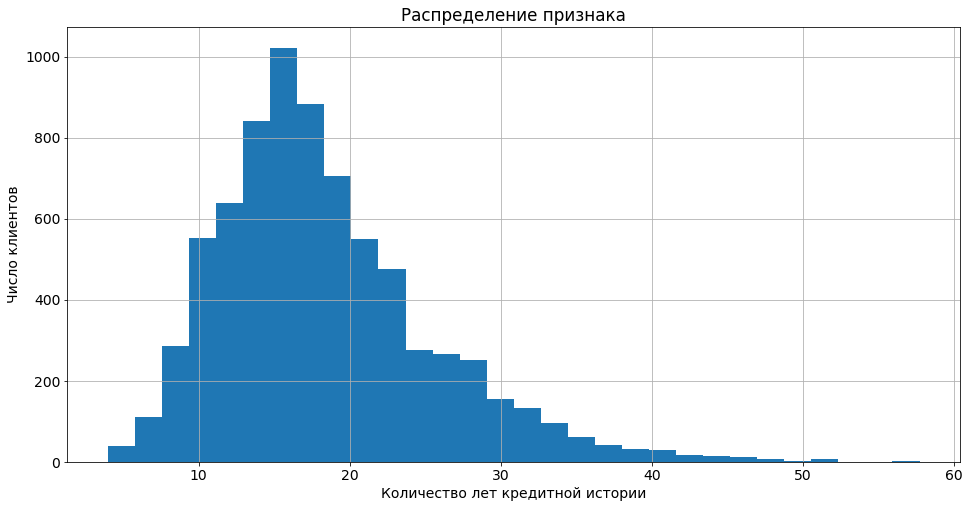

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Years of Credit History'].hist(bins=30)
plt.ylabel('Число клиентов')
plt.xlabel('Количество лет кредитной истории')

plt.title('Распределение признака')
plt.show()

In [ ]:
df_train.loc[(df_train['Years of Credit History'] >= 45), 'Number of Open Accounts'] = df_train['Number of Open Accounts'].median()

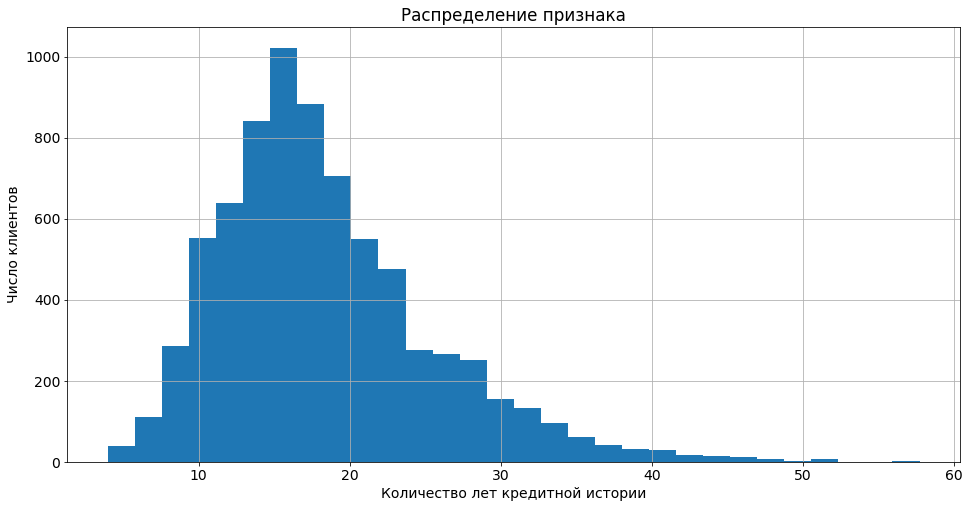

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Years of Credit History'].hist(bins=30)
plt.ylabel('Число клиентов')
plt.xlabel('Количество лет кредитной истории')

plt.title('Распределение признака')
plt.show()

Maximum Open Credit

In [ ]:
condition = (df_train['Maximum Open Credit'].isna()) \
             | (df_train['Maximum Open Credit'] > df_train['Maximum Open Credit'].quantile(.975))
        
df_train.loc[condition, 'Maximum Open Credit'] = df_train['Maximum Open Credit'].median()

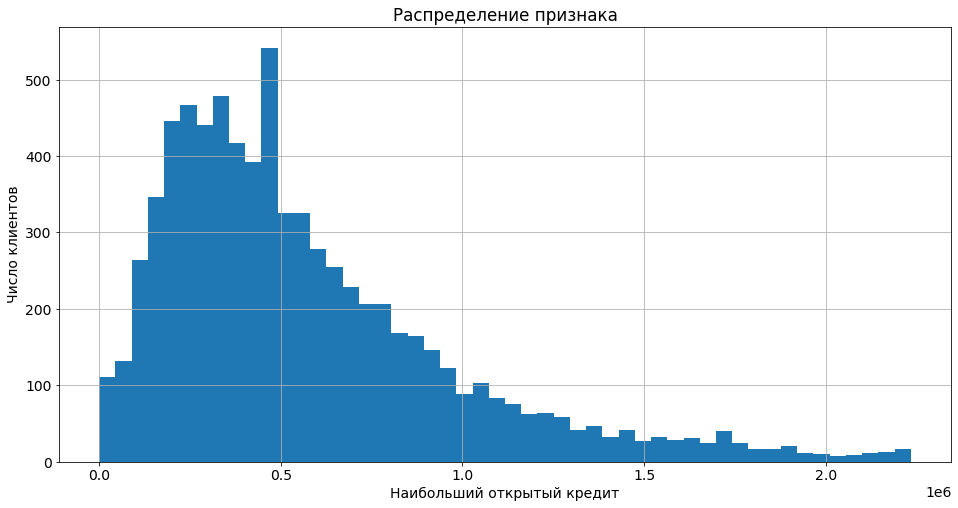

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Maximum Open Credit'].hist(bins=50)
plt.ylabel('Число клиентов')
plt.xlabel('Наибольший открытый кредит')

plt.title('Распределение признака')
plt.show()

Number of Credit Problems	

In [ ]:
df_train['Number of Credit Problems'].value_counts().reset_index()

,index,Number of Credit Problems
0,0.0,6469
1,1.0,882
2,2.0,93
3,3.0,35
4,4.0,9
5,5.0,7
6,6.0,4
7,7.0,1


In [ ]:
df_train.loc[(df_train['Number of Credit Problems'] > 4), 'Number of Credit Problems'] = 4

In [ ]:
df_train['Number of Credit Problems'].value_counts().reset_index()

,index,Number of Credit Problems
0,0.0,6469
1,1.0,882
2,2.0,93
3,3.0,35
4,4.0,21


Current Loan Amount - текущая сумма кредита

In [ ]:
df_train.loc[(df_train['Current Loan Amount'] > 1000000), 'Current Loan Amount'] = df_train['Current Loan Amount'].median()

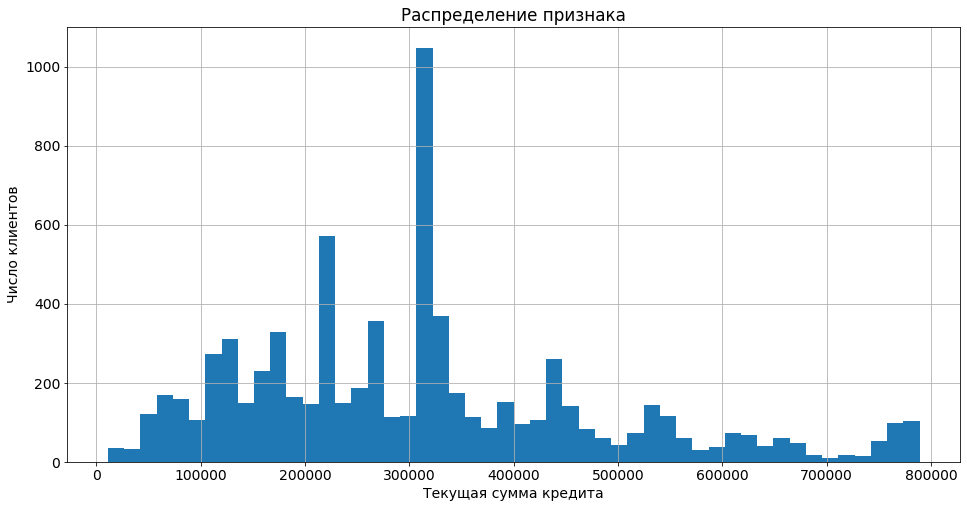

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Current Loan Amount'].hist(bins=50)
plt.ylabel('Число клиентов')
plt.xlabel('Текущая сумма кредита')

plt.title('Распределение признака')
plt.show()

Current Credit Balance - текущий кредитный баланс

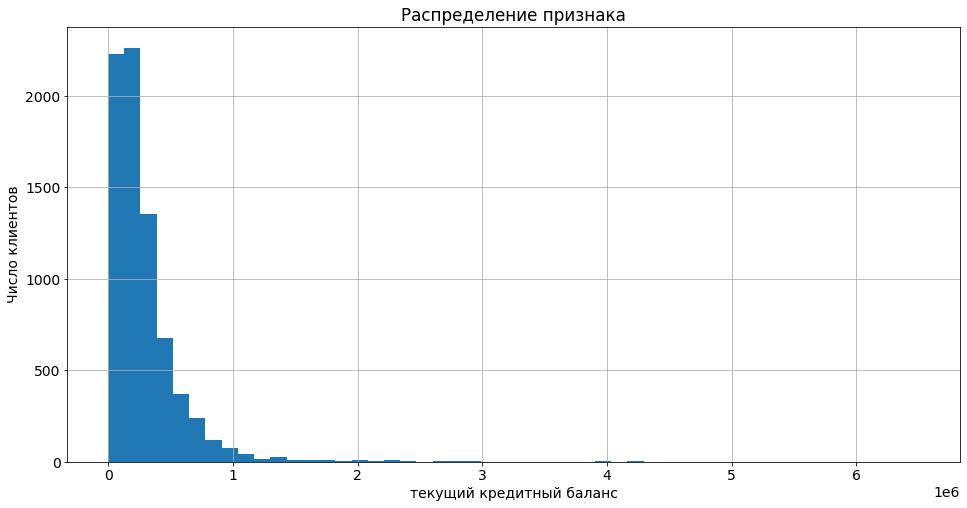

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Current Credit Balance'].hist(bins=50)
plt.ylabel('Число клиентов')
plt.xlabel('текущий кредитный баланс')

plt.title('Распределение признака')
plt.show()

In [ ]:
condition = (df_train['Current Credit Balance'].isna()) \
             | (df_train['Current Credit Balance'] > df_train['Current Credit Balance'].quantile(.975))
        
df_train.loc[condition, 'Current Credit Balance'] = df_train['Current Credit Balance'].median()

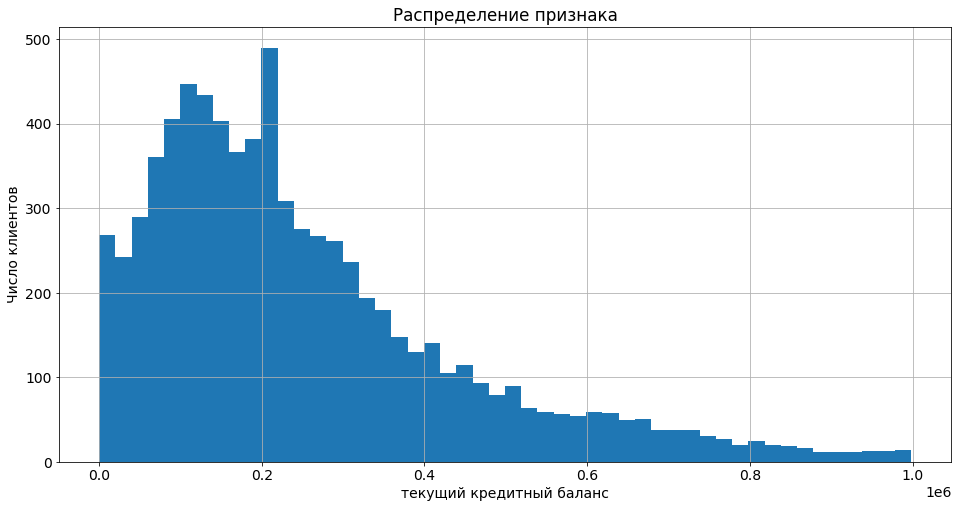

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Current Credit Balance'].hist(bins=50)
plt.ylabel('Число клиентов')
plt.xlabel('текущий кредитный баланс')

plt.title('Распределение признака')
plt.show()

Monthly Debt - ежемесячный долг

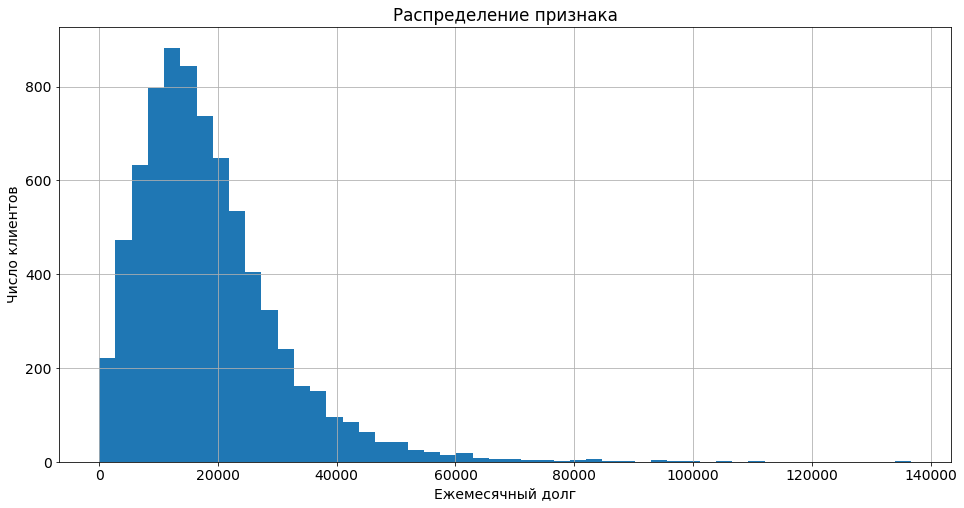

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Monthly Debt'].hist(bins=50)
plt.ylabel('Число клиентов')
plt.xlabel('Ежемесячный долг')

plt.title('Распределение признака')
plt.show()

In [ ]:
df_train.loc[(df_train['Monthly Debt'] > 80000), 'Monthly Debt'] = df_train['Monthly Debt'].median()

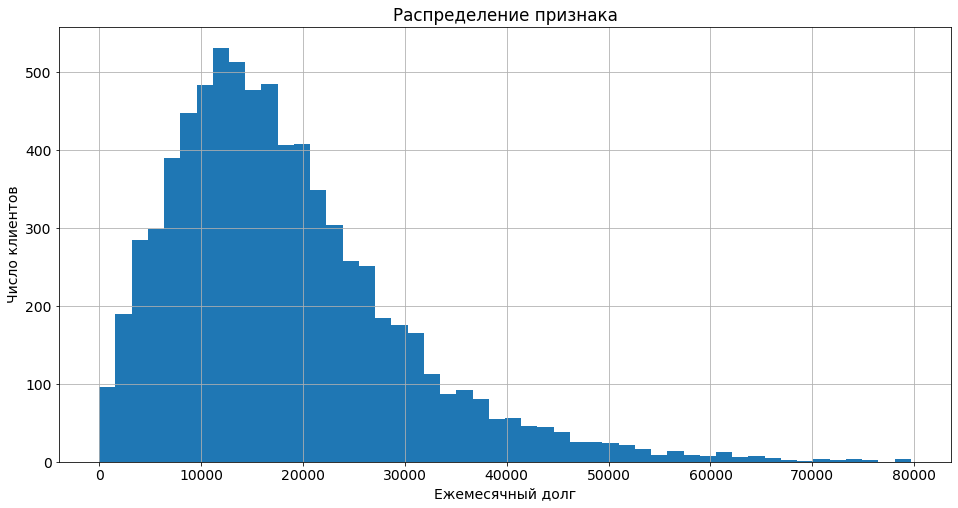

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Monthly Debt'].hist(bins=50)
plt.ylabel('Число клиентов')
plt.xlabel('Ежемесячный долг')

plt.title('Распределение признака')
plt.show()

###**Обработка пропусков**

Annual Income - годовой доход

In [ ]:
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income'] = df_train['Annual Income'].median()

In [ ]:
df_train['Annual Income'].isna().sum()

0

Bankruptcies

In [ ]:
df_train['Bankruptcies'].isna().sum()

14

In [ ]:
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = 0

In [ ]:
df_train['Bankruptcies'].isna().sum()

0

###**Перекодирование качественных признаков**

Term - срок кредита

In [ ]:
df_train['Term'].value_counts().reset_index()

,index,Term
0,Short Term,5556
1,Long Term,1944


In [ ]:
binary_to_numbers = {'Short Term': 0, 'Long Term': 1}

In [ ]:
df_train['Term'] = df_train['Term'].replace(binary_to_numbers)

In [ ]:
df_train['Term'].value_counts().reset_index()

,index,Term
0,0,5556
1,1,1944


Home Ownership

In [ ]:
df_train['Home Ownership'].value_counts().reset_index()

,index,Home Ownership
0,Home Mortgage,3637
1,Rent,3204
2,Own Home,647
3,Have Mortgage,12


In [ ]:
home_ownership_to_numbers = {'Rent' : 0, 'Home Mortgage': 1, 'Have Mortgage': 1, 'Own Home' : 2}

In [ ]:
df_train['Home Ownership'] = df_train['Home Ownership'].replace(home_ownership_to_numbers)

In [ ]:
df_train['Home Ownership'].value_counts().reset_index()

,index,Home Ownership
0,1,3649
1,0,3204
2,2,647


Years in current job

In [ ]:
df_train['Years in current job'].value_counts().reset_index()

,index,Years in current job
0,10+ years,2332
1,2 years,705
2,3 years,620
3,< 1 year,563
4,5 years,516
5,1 year,504
6,4 years,469
7,6 years,426
8,7 years,396
9,8 years,339


In [ ]:
year_to_numbers = {'< 1 year' : 0, '1 year' : 1, '2 years' : 1, '3 years' : 2, '4 years' : 2, '5 years' : 2, '6 years' : 3, '7 years' : 3, '8 years' : 3, '9 years' : 3, '10 years' : 3, '10+ years' : 4}

In [ ]:
df_train['Years in current job'] = df_train['Years in current job'].replace(year_to_numbers)

In [ ]:
df_train['Years in current job'].value_counts().reset_index()

,index,Years in current job
0,4.0,2332
1,2.0,1605
2,3.0,1420
3,1.0,1209
4,0.0,563


In [ ]:
# заполнение пропусков
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job'] = 2

In [ ]:
df_train['Years in current job'].isna().sum()

0

Purpose - цель кредита

In [ ]:
df_train['Purpose'].value_counts().reset_index()

,index,Purpose
0,debt consolidation,5944
1,other,665
2,home improvements,412
3,business loan,129
4,buy a car,96
5,medical bills,71
6,major purchase,40
7,take a trip,37
8,buy house,34
9,small business,26


In [ ]:
purpose_to_numbers = {'debt consolidation' : 0, 'other' : 1, 'wedding' : 1, 'moving' : 1, 'renewable energy' : 1, 'educational expenses' : 1,
                      'home improvements' : 2, 'business loan' : 3, 'small business' : 3,
                      'buy a car' : 4, 'medical bills' : 5, 'major purchase' : 6, 'take a trip' : 7, 'vacation' : 7, 'buy house' : 8}

In [ ]:
df_train['Purpose'] = df_train['Purpose'].replace(purpose_to_numbers)

In [ ]:
df_train['Purpose'].value_counts().reset_index()

,index,Purpose
0,0,5944
1,1,703
2,2,412
3,3,155
4,4,96
5,5,71
6,7,45
7,6,40
8,8,34


In [ ]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2,482087.0,2.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,0,0,309573.0,47386.0,7914.0,749.0,0
1,2,1025487.0,4.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,0,1,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,3.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,0,0,309573.0,308389.0,13651.0,742.0,0
3,2,805068.0,3.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,0,0,121396.0,95855.0,11338.0,694.0,0
4,0,776264.0,3.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,0,0,125840.0,93309.0,7180.0,719.0,0
5,0,1168386.0,3.0,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,1,1,337304.0,165680.0,18692.0,NaN,1
6,1,1511108.0,4.0,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,2,0,309573.0,51623.0,2317.0,745.0,0
7,0,1040060.0,4.0,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,1,0,250888.0,89015.0,19761.0,705.0,1
8,1,1168386.0,2.0,0.0,17.0,15.7,0.0,1.0,NaN,1.0,2,0,129734.0,19.0,17.0,NaN,0
9,1,1168386.0,1.0,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,0,1,572880.0,205333.0,17613.0,NaN,1


###**class DataPreprocessing**

In [ ]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.maximum_open_credit_quantile = None
        self.current_credit_balance_quantile = None

        
    def fit(self, X, y=None):
        
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.maximum_open_credit_quantile = X['Maximum Open Credit'].quantile(.975)
        self.current_credit_balance_quantile = X['Current Credit Balance'].quantile(.975)

    
    def transform(self, X):
        """Трансформация данных"""
        
        #Annual Income
        X.loc[(X['Annual Income'] >= 4000000), 'Annual Income'] = self.medians['Annual Income']
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']

        #Tax Liens
        X.loc[(X['Tax Liens'] > 3), 'Tax Liens'] = 3

        #Number of Open Accounts
        X.loc[(X['Number of Open Accounts'] >= 25) | (X['Number of Open Accounts'] == 0 ),
             'Number of Open Accounts'] = self.medians['Number of Open Accounts']

        #Years of Credit History
        X.loc[(X['Years of Credit History'] >= 45), 'Years of Credit History'] = self.medians['Years of Credit History']

        #Maximum Open Credit
        condition = (X['Maximum Open Credit'].isna()) \
             | (X['Maximum Open Credit'] > self.maximum_open_credit_quantile)
        
        X.loc[condition, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']

        #Number of Credit Problems
        X.loc[(X['Number of Credit Problems'] > 4), 'Number of Credit Problems'] = 4

        #Current Loan Amount
        X.loc[(X['Current Loan Amount'] > 1000000), 'Current Loan Amount'] = self.medians['Current Loan Amount']

        #Current Credit Balance
        condition = (X['Current Credit Balance'].isna()) \
             | (X['Current Credit Balance'] > self.current_credit_balance_quantile)
        
        X.loc[condition, 'Current Credit Balance'] = self.medians['Current Credit Balance']

        #Monthly Debt
        X.loc[(X['Monthly Debt'] > 80000), 'Monthly Debt'] = self.medians['Monthly Debt']

        #Bankruptcies
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = 0

        #Years in current job
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = '5 years'

        X.fillna(self.medians, inplace=True)

        return X

In [ ]:
class Recoder():
    """Перекодирование признаков"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.home_ownership_to_numbers = None
        self.year_to_numbers = None
        self.purpose_to_numbers = None
        
    def fit(self, X, y=None):
        
        #перекодирование качественных признаков
        
        self.binary_to_numbers= {'Short Term': 0, 'Long Term': 1}
        self.home_ownership_to_numbers = {'Rent' : 0, 'Home Mortgage': 1, 'Have Mortgage': 1, 'Own Home' : 2}
        self.year_to_numbers = {'< 1 year' : 0, '1 year' : 1, '2 years' : 1, '3 years' : 2, '4 years' : 2, '5 years' : 2,
                                '6 years' : 3, '7 years' : 3, '8 years' : 3, '9 years' : 3, '10 years' : 3, '10+ years' : 4}
        self.purpose_to_numbers = {'debt consolidation' : 0, 'other' : 1, 'wedding' : 1, 'moving' : 1, 'renewable energy' : 1, 'educational expenses' : 1,
                      'home improvements' : 2, 'business loan' : 3, 'small business' : 3,
                      'buy a car' : 4, 'medical bills' : 5, 'major purchase' : 6, 'take a trip' : 7, 'vacation' : 7, 'buy house' : 8}
        
    def transform(self, X):
        #Term
        X['Term'] = X['Term'].map(self.binary_to_numbers)

        #Home Ownership
        X['Home Ownership'] = X['Home Ownership'].map(self.home_ownership_to_numbers)

        #Years in current job
        X['Years in current job'] = X['Years in current job'].map(self.year_to_numbers)

        #Purpose
        X['Purpose'] = X['Purpose'].map(self.purpose_to_numbers)

        return X

###**Подготовка данных**

In [ ]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

In [ ]:
df_train = df_train.drop(columns='Months since last delinquent') # признак не будет использован тк > 50% данных пропущено

In [ ]:
df_train = df_train.drop(columns='Credit Score') # не поняла признак, в описании датасета его нет

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(df_train)

df_train = preprocessor.transform(df_train)


df_train.shape

(7500, 15)

In [ ]:
recoder = Recoder()
recoder.fit(df_train)

df_train = recoder.transform(df_train)

df_train.shape

(7500, 15)

In [ ]:
df_train.isna().sum().sum()

0

In [ ]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Default
0,2,482087.0,2,0.0,11.0,26.3,685960.0,1.0,1.0,0,0,309573.0,47386.0,7914.0,0
1,2,1025487.0,4,0.0,15.0,15.3,1181730.0,0.0,0.0,0,1,264968.0,394972.0,18373.0,1
2,1,751412.0,3,0.0,11.0,35.0,1182434.0,0.0,0.0,0,0,309573.0,308389.0,13651.0,0
3,2,805068.0,3,0.0,8.0,22.5,147400.0,1.0,1.0,0,0,121396.0,95855.0,11338.0,0
4,0,776264.0,3,0.0,13.0,13.6,385836.0,1.0,0.0,0,0,125840.0,93309.0,7180.0,0


##**Отбор признаков**

In [ ]:
df_train.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Default']

**Выделение целевой переменной и групп признаков**

In [ ]:
TARGET_NAME = 'Credit Default'

In [ ]:
FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
                 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Purpose',
                 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

In [ ]:
NUMERIC_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [ ]:
QUANTITATIVE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
                              'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                              'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

In [ ]:
FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + QUANTITATIVE_FEATURE_NAMES

###**Нормализация данных**

In [ ]:
'''scaler = StandardScaler()

df_train_norm = df_train.copy()
df_train_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_train_norm[NUMERIC_FEATURE_NAMES])

df_train = df_train_norm.copy()'''

## **Разбиение на train и test**

In [ ]:
X = df_train[FEATURE_NAMES_SELECTED]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

##**Балансировка целевой переменной**

In [ ]:
#Under-sampling:Tomek links
rus = RandomUnderSampler(random_state=42, replacement=True)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [ ]:
#SMOTE - не подошел
'''nm = NearMiss()
X_train, y_train = nm.fit_resample(X_train, y_train)'''

'nm = NearMiss()\nX_train, y_train = nm.fit_resample(X_train, y_train)'

In [ ]:
#неудачный метод
'''df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()'''

'df_for_balancing = pd.concat([X_train, y_train], axis=1)\ndf_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)\n    \ndf_balanced[TARGET_NAME].value_counts()'

In [ ]:
'''X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]'''

'X_train = df_balanced.drop(columns=TARGET_NAME)\ny_train = df_balanced[TARGET_NAME]'

##**Построение и оценка моделей**

**Логистическая регрессия**

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.57      0.62      0.59      1551
           1       0.58      0.52      0.55      1551

    accuracy                           0.57      3102
   macro avg       0.57      0.57      0.57      3102
weighted avg       0.57      0.57      0.57      3102

TEST

              precision    recall  f1-score   support

           0       0.74      0.63      0.68      1313
           1       0.36      0.50      0.42       562

    accuracy                           0.59      1875
   macro avg       0.55      0.56      0.55      1875
weighted avg       0.63      0.59      0.60      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               824  489
1               283  279


**k ближайших соседей**

In [ ]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      1551
           1       0.74      0.73      0.73      1551

    accuracy                           0.73      3102
   macro avg       0.73      0.73      0.73      3102
weighted avg       0.73      0.73      0.73      3102

TEST

              precision    recall  f1-score   support

           0       0.75      0.52      0.62      1313
           1       0.35      0.59      0.43       562

    accuracy                           0.54      1875
   macro avg       0.55      0.56      0.53      1875
weighted avg       0.63      0.54      0.56      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               689  624
1               233  329


**Бустинговые алгоритмы**

XGBoost

In [ ]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1551
           1       0.75      0.77      0.76      1551

    accuracy                           0.75      3102
   macro avg       0.76      0.75      0.75      3102
weighted avg       0.76      0.75      0.75      3102

TEST

              precision    recall  f1-score   support

           0       0.80      0.60      0.69      1313
           1       0.41      0.66      0.51       562

    accuracy                           0.62      1875
   macro avg       0.61      0.63      0.60      1875
weighted avg       0.69      0.62      0.63      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               785  528
1               191  371


LightGBM

In [ ]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1551
           1       0.95      0.96      0.95      1551

    accuracy                           0.95      3102
   macro avg       0.95      0.95      0.95      3102
weighted avg       0.95      0.95      0.95      3102

TEST

              precision    recall  f1-score   support

           0       0.79      0.58      0.67      1313
           1       0.40      0.65      0.49       562

    accuracy                           0.60      1875
   macro avg       0.60      0.61      0.58      1875
weighted avg       0.67      0.60      0.62      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               756  557
1               196  366


CatBoost

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1551
           1       0.87      0.90      0.89      1551

    accuracy                           0.88      3102
   macro avg       0.88      0.88      0.88      3102
weighted avg       0.88      0.88      0.88      3102

TEST

              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1313
           1       0.41      0.69      0.51       562

    accuracy                           0.61      1875
   macro avg       0.61      0.63      0.59      1875
weighted avg       0.69      0.61      0.62      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               748  565
1               173  389


###**Выбор лучшей модели и подбор гиперпараметров**

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

**Подбор гиперпараметров**

In [ ]:
params = {'n_estimators':[50, 100, 200, 500], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [ ]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
'''%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)'''

CPU times: user 2.29 s, sys: 271 ms, total: 2.56 s
Wall time: 29.5 s


In [ ]:
#rs.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}

In [ ]:
#rs.best_score_

0.6786815065038203

**Обучение и оценка финальной модели**

In [ ]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=5, learning_rate=0.05,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1551
           1       0.87      0.90      0.88      1551

    accuracy                           0.88      3102
   macro avg       0.88      0.88      0.88      3102
weighted avg       0.88      0.88      0.88      3102

TEST

              precision    recall  f1-score   support

           0       0.80      0.56      0.66      1313
           1       0.40      0.67      0.50       562

    accuracy                           0.59      1875
   macro avg       0.60      0.62      0.58      1875
weighted avg       0.68      0.59      0.61      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               733  580
1               183  379
CPU times: user 1.96 s, sys: 653 ms, total: 2.61 s
Wall time: 2.52 s


**Снижение степени переобучения**

In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=5, learning_rate=0.05,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1551
           1       0.85      0.89      0.87      1551

    accuracy                           0.87      3102
   macro avg       0.87      0.87      0.87      3102
weighted avg       0.87      0.87      0.87      3102

TEST

              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1313
           1       0.40      0.68      0.51       562

    accuracy                           0.60      1875
   macro avg       0.60      0.62      0.59      1875
weighted avg       0.69      0.60      0.62      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               743  570
1               178  384


**Важность признаков**

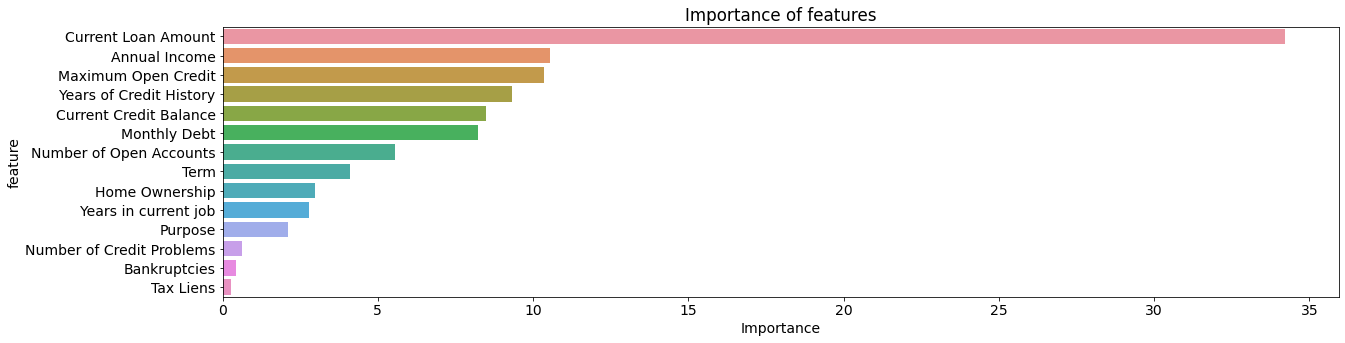

In [ ]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=11)

In [ ]:
important_features_top

['Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Years of Credit History',
 'Current Credit Balance',
 'Monthly Debt',
 'Number of Open Accounts',
 'Term',
 'Home Ownership',
 'Years in current job',
 'Purpose']

**Финальная модель**

In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=5, 
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1551
           1       0.79      0.84      0.82      1551

    accuracy                           0.81      3102
   macro avg       0.81      0.81      0.81      3102
weighted avg       0.81      0.81      0.81      3102

TEST

              precision    recall  f1-score   support

           0       0.81      0.58      0.67      1313
           1       0.41      0.67      0.51       562

    accuracy                           0.61      1875
   macro avg       0.61      0.63      0.59      1875
weighted avg       0.69      0.61      0.62      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               762  551
1               184  378


###**Предсказание на тестовой выборке**

In [ ]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [ ]:
df_test = df_test.drop(columns='Months since last delinquent')

In [ ]:
df_test = df_test.drop(columns='Credit Score')

In [ ]:
df_test.shape

(2500, 14)

In [ ]:
df_test= preprocessor.transform(df_test)
df_test.shape

(2500, 14)

In [ ]:
df_test = recoder.transform(df_test)

df_test.shape

(2500, 14)

In [ ]:
df_test.isna().sum().sum()

0

In [ ]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt
0,0,1168386.0,2,0.0,9.0,12.5,220968.0,0.0,0.0,0,0,162470.0,105906.0,6813.0
1,0,231838.0,1,0.0,6.0,32.7,55946.0,0.0,0.0,1,0,78298.0,46037.0,2318.0
2,1,1152540.0,2,0.0,10.0,13.7,204600.0,0.0,0.0,0,0,200178.0,146490.0,18729.0
3,1,1220313.0,4,0.0,16.0,17.0,456302.0,0.0,0.0,0,0,217382.0,213199.0,27559.0
4,1,2340952.0,3,0.0,11.0,23.6,1207272.0,0.0,0.0,0,1,777634.0,425391.0,42605.0


In [ ]:
'''df_test_norm = df_test.copy()
df_test_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_test_norm[NUMERIC_FEATURE_NAMES])

df_test = df_test_norm.copy()'''

'df_test_norm = df_test.copy()\ndf_test_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_test_norm[NUMERIC_FEATURE_NAMES])\n\ndf_test = df_test_norm.copy()'

In [ ]:
predictions = final_model.predict(df_test[important_features_top])
predictions

array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
df_test['Predictions'] = predictions
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Predictions
0,0,1168386.0,2,0.0,9.0,12.5,220968.0,0.0,0.0,0,0,162470.0,105906.0,6813.0,1
1,0,231838.0,1,0.0,6.0,32.7,55946.0,0.0,0.0,1,0,78298.0,46037.0,2318.0,1
2,1,1152540.0,2,0.0,10.0,13.7,204600.0,0.0,0.0,0,0,200178.0,146490.0,18729.0,0
3,1,1220313.0,4,0.0,16.0,17.0,456302.0,0.0,0.0,0,0,217382.0,213199.0,27559.0,1
4,1,2340952.0,3,0.0,11.0,23.6,1207272.0,0.0,0.0,0,1,777634.0,425391.0,42605.0,0


In [ ]:
df_predictions = df_test['Predictions']
df_predictions

0       1
1       1
2       0
3       1
4       0
       ..
2495    0
2496    1
2497    0
2498    1
2499    1
Name: Predictions, Length: 2500, dtype: int64

In [ ]:
df_predictions.to_csv('NSafronova_predictions.csv')